In [400]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import scipy.sparse as sp
import json
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import f_oneway
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score,roc_curve
from textblob import TextBlob

In [366]:
df_llm = pd.read_csv("../Data/processed_yelp_reviews.csv")
df_llm.head()
df_llm.head()

,user_id,business_id,text,food,service,price
0,5TE19zTjTIPq1HANACN7sw,dChRGpit9fM_kZK5pafNyA,Had a great big meal with family and we loved ...,1,1,0
1,5Z8S9OsHWCnE8wbxk1poQQ,s3Q1J4XEVOBiZy9dYUpqpg,Many locations. All have lines so be prepared...,1,0,0
2,hcw7ndQKWGEH4P7BYAlG9w,JUlsvVAvZvGHWFfkKm0nlg,Compliments to the chef and to the rest of the...,1,1,0
3,OYaEBYLBrLY4mla8bOMbnA,9b0Mrvs6uJu2jJqet_Jwew,I decided to try this spot out -- and it didn'...,0,1,1
4,_9VhEn9zaB-6txE3STNfLw,PYUI1OJVksGUbCrteU68bw,"First off, finding parking is atrocious. Your ...",-1,0,0


In [367]:
df_all = pd.read_csv("../Data/yelp_2020_new.csv")
df_all["food"] = df_llm["food"]
df_all["service"] = df_llm["service"]
df_all["price"] = df_llm["price"]
df_all.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,exist_WiFi,review_count_usr,yelping_since_usr,useful_cnt_usr,funny_cnt_usr,cool_cnt_usr,elite_usr,food,service,price
0,J1LZjzbs5bFubvS135SD2g,5TE19zTjTIPq1HANACN7sw,dChRGpit9fM_kZK5pafNyA,5.0,1,0,1,Had a great big meal with family and we loved ...,2020-01-20 00:36:44,The Love,...,1,378,2012-08-26 13:01:03,365,67,176,"2013,2014,2015,2016,2017,2018,2019,20,20,2021",1,1,0
1,ecMiAOFucDM3zwXYfY-Q6A,5Z8S9OsHWCnE8wbxk1poQQ,s3Q1J4XEVOBiZy9dYUpqpg,5.0,0,0,0,Many locations. All have lines so be prepared...,2020-02-16 22:52:13,Green Eggs Cafe,...,1,36,2012-03-01 17:46:32,27,13,4,NaN,1,0,0
2,yuFQRhHo3z4TgE6drPXSgg,hcw7ndQKWGEH4P7BYAlG9w,JUlsvVAvZvGHWFfkKm0nlg,5.0,1,0,0,Compliments to the chef and to the rest of the...,2020-01-12 00:55:58,El Camino Real,...,1,100,2019-06-26 14:08:01,66,19,22,"2019,20,20,2021",1,1,0
3,Zdh0_HtE724MnohLOrB5Iw,OYaEBYLBrLY4mla8bOMbnA,9b0Mrvs6uJu2jJqet_Jwew,4.0,0,0,0,I decided to try this spot out -- and it didn'...,2020-01-15 19:29:25,Asia Nail 2 & Spa,...,1,1,2014-10-12 01:07:21,0,0,0,NaN,0,1,1
4,y_XYEZk2Cin-q4N0czeaYw,_9VhEn9zaB-6txE3STNfLw,PYUI1OJVksGUbCrteU68bw,3.0,0,0,0,"First off, finding parking is atrocious. Your ...",2020-02-17 13:53:51,Bourbon & Branch,...,1,4,2015-08-09 22:08:50,3,0,1,NaN,-1,0,0


In [368]:
df_all.shape

(50203, 47)

In [369]:
def clean_text(text):
    # remove html tags
    text = re.sub(r"<.*?>", "", text)
    # remove the none-letter characters
    text = re.sub(r"[^a-zA-Z]", " ", text)
    # change to lower case and strip white spaces
    text = text.lower().strip()
    return text


# 应用clean_text到评论数据
df_all["cleaned_reviews"] = df_all["text"].apply(clean_text)

In [370]:
def get_sentiment(text):
    # use TextBlob to get the sentiment
    analysis = TextBlob(text)
    return analysis.sentiment.polarity


# add sentiment to the data
df_all["sentiment"] = df_all["cleaned_reviews"].apply(get_sentiment)

In [371]:
df_all.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,yelping_since_usr,useful_cnt_usr,funny_cnt_usr,cool_cnt_usr,elite_usr,food,service,price,cleaned_reviews,sentiment
0,J1LZjzbs5bFubvS135SD2g,5TE19zTjTIPq1HANACN7sw,dChRGpit9fM_kZK5pafNyA,5.0,1,0,1,Had a great big meal with family and we loved ...,2020-01-20 00:36:44,The Love,...,2012-08-26 13:01:03,365,67,176,"2013,2014,2015,2016,2017,2018,2019,20,20,2021",1,1,0,had a great big meal with family and we loved ...,0.436111
1,ecMiAOFucDM3zwXYfY-Q6A,5Z8S9OsHWCnE8wbxk1poQQ,s3Q1J4XEVOBiZy9dYUpqpg,5.0,0,0,0,Many locations. All have lines so be prepared...,2020-02-16 22:52:13,Green Eggs Cafe,...,2012-03-01 17:46:32,27,13,4,NaN,1,0,0,many locations all have lines so be prepared...,0.437500
2,yuFQRhHo3z4TgE6drPXSgg,hcw7ndQKWGEH4P7BYAlG9w,JUlsvVAvZvGHWFfkKm0nlg,5.0,1,0,0,Compliments to the chef and to the rest of the...,2020-01-12 00:55:58,El Camino Real,...,2019-06-26 14:08:01,66,19,22,"2019,20,20,2021",1,1,0,compliments to the chef and to the rest of the...,0.105578
3,Zdh0_HtE724MnohLOrB5Iw,OYaEBYLBrLY4mla8bOMbnA,9b0Mrvs6uJu2jJqet_Jwew,4.0,0,0,0,I decided to try this spot out -- and it didn'...,2020-01-15 19:29:25,Asia Nail 2 & Spa,...,2014-10-12 01:07:21,0,0,0,NaN,0,1,1,i decided to try this spot out and it didn ...,0.355312
4,y_XYEZk2Cin-q4N0czeaYw,_9VhEn9zaB-6txE3STNfLw,PYUI1OJVksGUbCrteU68bw,3.0,0,0,0,"First off, finding parking is atrocious. Your ...",2020-02-17 13:53:51,Bourbon & Branch,...,2015-08-09 22:08:50,3,0,1,NaN,-1,0,0,first off finding parking is atrocious your ...,0.073619


In [372]:
item_funny_dic = df_all.groupby("business_id")["funny"].sum().to_dict()
item_useful_dic = df_all.groupby("business_id")["useful"].sum().to_dict()
item_cool_dic = df_all.groupby("business_id")["cool"].sum().to_dict()
item_senti_dic = df_all.groupby("business_id")["sentiment"].mean().to_dict()

item_food_dic = df_all.groupby("business_id")["food"].sum().to_dict()
item_service_dic = df_all.groupby("business_id")["service"].sum().to_dict()
item_price_dic = df_all.groupby("business_id")["price"].sum().to_dict()

item_cnt_dic = df_all.groupby("business_id")["service"].count().to_dict()

usr_food_dic = df_all.groupby("user_id")["food"].sum().to_dict()
usr_service_dic = df_all.groupby("user_id")["service"].sum().to_dict()
usr_price_dic = df_all.groupby("user_id")["price"].sum().to_dict()

usr_cnt_dic = df_all.groupby("user_id")["service"].count().to_dict()

usr_senti_dic = df_all.groupby("user_id")["sentiment"].mean().to_dict()

df_all["funny_item"] = df_all["business_id"].apply(lambda x:item_funny_dic[x])
df_all["useful_item"] = df_all["business_id"].apply(lambda x: item_useful_dic[x])
df_all["cool_item"] = df_all["business_id"].apply(lambda x: item_cool_dic[x])
df_all["senti_user"] = df_all["user_id"].apply(lambda x: usr_senti_dic[x])
df_all["senti_item"] = df_all["business_id"].apply(lambda x: item_senti_dic[x])

df_all["food_item"] = df_all["business_id"].apply(lambda x: item_food_dic[x]/item_cnt_dic[x])
df_all["service_item"] = df_all["business_id"].apply(
    lambda x: item_service_dic[x] / item_cnt_dic[x]
)
df_all["price_item"] = df_all["business_id"].apply(
    lambda x: item_price_dic[x] / item_cnt_dic[x]
)
df_all["cnt_item"] = df_all["business_id"].apply(
    lambda x: item_cnt_dic[x]
)

df_all["food_user"] = df_all["user_id"].apply(
    lambda x: usr_food_dic[x] / usr_cnt_dic[x]
)
df_all["service_user"] = df_all["user_id"].apply(
    lambda x: usr_service_dic[x] / usr_cnt_dic[x]
)
df_all["price_user"] = df_all["user_id"].apply(
    lambda x: usr_price_dic[x] / usr_cnt_dic[x]
)
df_all["cnt_user"] = df_all["user_id"].apply(
    lambda x: usr_cnt_dic[x]
)

df_all.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,senti_user,senti_item,food_item,service_item,price_item,cnt_item,food_user,service_user,price_user,cnt_user
0,J1LZjzbs5bFubvS135SD2g,5TE19zTjTIPq1HANACN7sw,dChRGpit9fM_kZK5pafNyA,5.0,1,0,1,Had a great big meal with family and we loved ...,2020-01-20 00:36:44,The Love,...,0.327646,0.305918,0.695122,0.670732,0.097561,82,0.333333,0.333333,0.000000,3
1,ecMiAOFucDM3zwXYfY-Q6A,5Z8S9OsHWCnE8wbxk1poQQ,s3Q1J4XEVOBiZy9dYUpqpg,5.0,0,0,0,Many locations. All have lines so be prepared...,2020-02-16 22:52:13,Green Eggs Cafe,...,0.292912,0.091376,-0.111111,0.222222,0.055556,18,-0.500000,-0.750000,-0.500000,4
2,yuFQRhHo3z4TgE6drPXSgg,hcw7ndQKWGEH4P7BYAlG9w,JUlsvVAvZvGHWFfkKm0nlg,5.0,1,0,0,Compliments to the chef and to the rest of the...,2020-01-12 00:55:58,El Camino Real,...,0.165183,0.160785,-0.461538,-0.230769,-0.307692,26,0.117647,-0.058824,-0.058824,17
3,Zdh0_HtE724MnohLOrB5Iw,OYaEBYLBrLY4mla8bOMbnA,9b0Mrvs6uJu2jJqet_Jwew,4.0,0,0,0,I decided to try this spot out -- and it didn'...,2020-01-15 19:29:25,Asia Nail 2 & Spa,...,0.355312,0.336048,-0.200000,0.500000,-0.100000,10,0.000000,1.000000,1.000000,1
4,y_XYEZk2Cin-q4N0czeaYw,_9VhEn9zaB-6txE3STNfLw,PYUI1OJVksGUbCrteU68bw,3.0,0,0,0,"First off, finding parking is atrocious. Your ...",2020-02-17 13:53:51,Bourbon & Branch,...,0.073619,0.154653,0.156250,0.156250,0.000000,32,-1.000000,0.000000,0.000000,1


In [373]:
df_train = pd.read_csv("../Data/Train_data_1201.csv",index_col = 0)
df_train.head()

,user_id,business_id,stars_x
6497,0,911,4.0
41933,0,6266,4.0
33508,1,5295,2.0
45147,1,7004,2.0
47218,1,7004,2.0


In [374]:
df_test = pd.read_csv("../Data/Test_data_1201.csv",index_col = 0)
df_test.head()

,user_id,business_id,stars_x
0,0,0,5.0
1,1,1,5.0
35931,2,5411,5.0
15172,2,2261,5.0
27351,2,4062,3.0


In [375]:
with open("../Data/user_id_dict.json", "r", encoding="utf-8") as file:
    usr_dict = json.load(file)

with open("../Data/business_id_dict.json", "r", encoding="utf-8") as file:
    item_dict = json.load(file)

In [376]:
df_all["user_id"] = df_all["user_id"].map(usr_dict)
df_all["business_id"] = df_all["business_id"].map(item_dict)

df_all.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,senti_user,senti_item,food_item,service_item,price_item,cnt_item,food_user,service_user,price_user,cnt_user
0,J1LZjzbs5bFubvS135SD2g,0,0,5.0,1,0,1,Had a great big meal with family and we loved ...,2020-01-20 00:36:44,The Love,...,0.327646,0.305918,0.695122,0.670732,0.097561,82,0.333333,0.333333,0.000000,3
1,ecMiAOFucDM3zwXYfY-Q6A,1,1,5.0,0,0,0,Many locations. All have lines so be prepared...,2020-02-16 22:52:13,Green Eggs Cafe,...,0.292912,0.091376,-0.111111,0.222222,0.055556,18,-0.500000,-0.750000,-0.500000,4
2,yuFQRhHo3z4TgE6drPXSgg,2,2,5.0,1,0,0,Compliments to the chef and to the rest of the...,2020-01-12 00:55:58,El Camino Real,...,0.165183,0.160785,-0.461538,-0.230769,-0.307692,26,0.117647,-0.058824,-0.058824,17
3,Zdh0_HtE724MnohLOrB5Iw,3,3,4.0,0,0,0,I decided to try this spot out -- and it didn'...,2020-01-15 19:29:25,Asia Nail 2 & Spa,...,0.355312,0.336048,-0.200000,0.500000,-0.100000,10,0.000000,1.000000,1.000000,1
4,y_XYEZk2Cin-q4N0czeaYw,4,4,3.0,0,0,0,"First off, finding parking is atrocious. Your ...",2020-02-17 13:53:51,Bourbon & Branch,...,0.073619,0.154653,0.156250,0.156250,0.000000,32,-1.000000,0.000000,0.000000,1


In [377]:
with open("../Data/user_top_k.pkl", "rb") as file:  # 以二进制模式读取
    usr_rec = pickle.load(file)

## Set features included

In [378]:
user_binary_cols = []  # 用户二分类特征列
user_num_cols = [
    "review_count_usr",
    "useful_cnt_usr",
    "funny_cnt_usr",
    "cool_cnt_usr",
]  # 用户数值特征列
user_class_cols = []  # 用户多分类特征列

item_binary_cols = [
    "BusinessAcceptsCreditCards",
    # "BusinessParking",
    "RestaurantsPriceRange2",
    "BikeParking",
    "RestaurantsTakeOut",
    "RestaurantsDelivery",
    "WiFi",
    # "GoodForKids",
    # "OutdoorSeating",
    # "RestaurantsReservations",
    "exist_BusinessAcceptsCreditCards",
    "exist_RestaurantsPriceRange2",
    "exist_BikeParking",
    "exist_RestaurantsTakeOut",
    "exist_RestaurantsDelivery",
    "exist_WiFi",
]  # 商品二分类特征列

item_num_cols = ["useful_item", "funny_item", "cool_item"]  # 商品数值特征列
item_class_cols = []  # 商品多分类特征列

y_label = ["stars_x"]


def dataset_preprocess(
    df,
    user_num_cols,
    item_binary_cols,
    item_num_cols,
    have_y=True,
):
    y = None
    if have_y:
        y = df["stars_x"].apply(lambda x: 1 if x in [4, 5] else 0)
    X = df[user_num_cols + item_binary_cols + item_num_cols]
    return X, y




## Metrics

In [379]:
def dcg_at_k(y_true, k):
    """DCG@k"""
    y_true = np.array(y_true)
    return np.sum(y_true[:k] / np.log2(np.arange(2, min(len(y_true),k) + 2)))


def ndcg_at_k(l1, l2, k): # l1:target, l2:rec
    """nDCG@k"""
    # 生成目标列表中元素的相关性（1表示相关，0表示不相关）
    y_true = [1 if item in l1 else 0 for item in l2]

    # 计算 DCG
    dcg = dcg_at_k(y_true, k)

    # 计算理想的 DCG (IDCG) —— 假设理想排序是按照 l1 本身排序
    ideal_y_true = [1 for item in l1]
    ideal_dcg = dcg_at_k(ideal_y_true, k)

    # 计算 nDCG
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0


# 示例数据
l1 = [1, 2]  # 目标列表（实际相关的推荐项）
l2 = [3, 1, 2]  # 推荐系统推荐的排序列表

k = 3  # 计算前 k 个推荐项的 nDCG

# 计算 nDCG@k
ndcg = ndcg_at_k(l1, l2, k)
print(f"nDCG@{k}: {ndcg}")

nDCG@3: 0.6934264036172708


## Train And Evaluate Model

In [396]:
def train_gbdt_lr(df_train,df_test,user_num_cols, item_binary_cols, item_num_cols):

    train_X, train_y = dataset_preprocess(
        df_train, user_num_cols, item_binary_cols, item_num_cols
    )
    test_X, test_y = dataset_preprocess(
        df_test,
        user_num_cols,
        item_binary_cols,
        item_num_cols,
    )

    # GBDT 模型训练

    gbdt_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)
    gbdt_model.fit(
        train_X,
        train_y,
        eval_set=[(test_X,test_y)],
        #early_stopping_rounds=10,
        #verbose=True,
    )

    # 提取 GBDT 输出的叶子节点
    gbdt_train_leaf = gbdt_model.predict(train_X, pred_leaf=True)
    gbdt_val_leaf = gbdt_model.predict(test_X, pred_leaf=True)

    # 叶子节点 One-Hot 编码
    leaf_encoder = OneHotEncoder(categories="auto", sparse=True)
    gbdt_train_onehot = leaf_encoder.fit_transform(gbdt_train_leaf)
    gbdt_val_onehot = leaf_encoder.transform(gbdt_val_leaf)

    # 合并 GBDT 特征和原始数值特征
    train_features = sp.hstack((gbdt_train_onehot, train_X))
    val_features = sp.hstack((gbdt_val_onehot, test_X))

    # LR 模型训练
    lr_model = LogisticRegression(max_iter=100)
    lr_model.fit(train_features, train_y)

    # 模型预测
    y_pred = lr_model.predict(val_features)
    y_proba = lr_model.predict_proba(val_features)

    fpr, tpr, thresholds = roc_curve(test_y, y_proba[:,1])

    auc = roc_auc_score(test_y, y_proba[:, 1])

    print(f"AUC: {auc}")

    return gbdt_model,lr_model,auc,(fpr,tpr)

# 评估模型

In [381]:
def dataset_preprocess(
    df,
    user_num_cols,
    item_binary_cols,
    item_num_cols,
    have_y=True,
):
    y = None
    if have_y:
        y = df["stars_x"].apply(lambda x: 1 if x in [4, 5] else 0)
    X = df[user_num_cols + item_binary_cols + item_num_cols]
    return X, y

In [382]:
def recommendK(
    user_id, k, gbdt_model, lr_model, user_num_cols, item_binary_cols, item_num_cols
):
    user_business_list = []
    for business_id in usr_rec[user_id]:
        user_business_list.append({"user_id": user_id, "business_id": business_id})
    user_inf_df = pd.DataFrame(user_business_list)
    user_inf_df = user_inf_df.merge(df_user, on="user_id", how="left").merge(
        df_business, on="business_id", how="left"
    )
    X, _ = dataset_preprocess(
        user_inf_df, user_num_cols, item_binary_cols, item_num_cols, False
    )

    gbdt_leaf = gbdt_model.predict(X, pred_leaf=True)
    gbdt_onehot = leaf_encoder.transform(gbdt_leaf)

    # 合并 GBDT 特征和原始数值特征
    features = sp.hstack((gbdt_onehot, X))
    y_proba = lr_model.predict_proba(features)

    user_inf_df["y_prob"] = y_proba[:, 1]
    top_k_ids = user_inf_df.nlargest(k, "y_prob")["business_id"].to_list()

    return top_k_ids

In [383]:
def eval_at_K(gbdt_model, lr_model, k, user_num_cols, item_binary_cols, item_num_cols):
    total_cnt = 0
    pos_cnt = 0
    cnt = 0
    sum_ndcg = 0
    for user_id, item_list in tqdm(
        test_positive_dic.items(), desc="Processing", total=len(test_positive_dic)
    ):
        rec = recommendK(
            user_id,
            k,
            gbdt_model,
            lr_model,
            user_num_cols,
            item_binary_cols,
            item_num_cols,
        )
        total_cnt += len(item_list)
        com = set(rec) & set(item_list)
        pos_cnt += len(com)
        cnt += 1
        sum_ndcg += ndcg_at_k(item_list, rec, k)
    # print("total_cnt: ",total_cnt)
    # print("pos_cnt: ",pos_cnt)
    recall = pos_cnt / total_cnt
    ndcg = sum_ndcg / cnt
    print(f"recall@{k}: {recall:.3f}")
    print(f"ndcg@{k}: {ndcg:.3f}")

    return recall, ndcg

## Without text features

In [420]:
user_binary_cols = []  # 用户二分类特征列
user_num_cols = [
    "review_count_usr",
    "useful_cnt_usr",
    "funny_cnt_usr",
    "cool_cnt_usr",
]  # 用户数值特征列
user_class_cols = []  # 用户多分类特征列

item_binary_cols = [
    "BusinessAcceptsCreditCards",
    # "BusinessParking",
    "RestaurantsPriceRange2",
    "BikeParking",
    "RestaurantsTakeOut",
    "RestaurantsDelivery",
    "WiFi",
    # "GoodForKids",
    # "OutdoorSeating",
    # "RestaurantsReservations",
    "exist_BusinessAcceptsCreditCards",
    "exist_RestaurantsPriceRange2",
    "exist_BikeParking",
    "exist_RestaurantsTakeOut",
    "exist_RestaurantsDelivery",
    "exist_WiFi",
]  # 商品二分类特征列

item_num_cols = ["useful_item", "funny_item", "cool_item"]  # 商品数值特征列
item_class_cols = []  # 商品多分类特征列

y_label = ["stars_x"]


df_business = df_all[
    ["business_id"] + item_binary_cols + item_num_cols
].drop_duplicates()
df_user = df_all[["user_id"] + user_num_cols].drop_duplicates()

df_train_merged = df_train.merge(df_user, on="user_id", how="left").merge(
    df_business, on="business_id", how="left"
)
df_test_merged = df_test.merge(df_user, on="user_id", how="left").merge(
    df_business, on="business_id", how="left"
)

_, y = dataset_preprocess(df_test_merged, user_num_cols, item_binary_cols, item_num_cols)
df_test_merged["y"] = y
test_positive_dic = (
    df_test_merged[df_test_merged["y"] == 1].groupby("user_id")["business_id"].apply(list).to_dict()
)
test_negative_dic = (
    df_test_merged[df_test_merged["y"] == 0].groupby("user_id")["business_id"].apply(list).to_dict()
)

In [421]:
gbdt_model, lr_model, auc,(fpr_0,tpr_0) = train_gbdt_lr(
    df_train_merged, df_test_merged, user_num_cols, item_binary_cols, item_num_cols
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 42416, number of used features: 13
[LightGBM] [Info] Start training from score 0.686840


/Users/zhenyu/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AUC: 0.6329886144830892


/Users/zhenyu/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [386]:
k_list = [50,100,200,500]
for k in k_list:
    recall,ndcg = eval_at_K(gbdt_model, lr_model, k, user_num_cols, item_binary_cols, item_num_cols)
    print(f"recall@{k}: {recall:.3f}\n")
    print(f"ndcg@{k}: {ndcg:.3f}\n")



Processing: 100%|██████████| 2921/2921 [04:15<00:00, 11.42it/s]


recall@50: 0.083
ndcg@50: 0.026
recall@50: 0.083

ndcg@50: 0.026



Processing: 100%|██████████| 2921/2921 [04:21<00:00, 11.19it/s]


recall@100: 0.140
ndcg@100: 0.036
recall@100: 0.140

ndcg@100: 0.036



Processing: 100%|██████████| 2921/2921 [05:22<00:00,  9.07it/s]


recall@200: 0.209
ndcg@200: 0.047
recall@200: 0.209

ndcg@200: 0.047



Processing: 100%|██████████| 2921/2921 [05:09<00:00,  9.44it/s]

recall@500: 0.352
ndcg@500: 0.067
recall@500: 0.352

ndcg@500: 0.067



## With text features

In [402]:
user_binary_cols = []  # 用户二分类特征列
user_num_cols = [
    "review_count_usr",
    "useful_cnt_usr",
    "funny_cnt_usr",
    "cool_cnt_usr",
    "senti_user"
]  # 用户数值特征列
user_class_cols = []  # 用户多分类特征列

item_binary_cols = [
    "BusinessAcceptsCreditCards",
    # "BusinessParking",
    "RestaurantsPriceRange2",
    "BikeParking",
    "RestaurantsTakeOut",
    "RestaurantsDelivery",
    "WiFi",
    # "GoodForKids",
    # "OutdoorSeating",
    # "RestaurantsReservations",
    "exist_BusinessAcceptsCreditCards",
    "exist_RestaurantsPriceRange2",
    "exist_BikeParking",
    "exist_RestaurantsTakeOut",
    "exist_RestaurantsDelivery",
    "exist_WiFi",
]  # 商品二分类特征列

item_num_cols = ["useful_item", "funny_item", "cool_item","senti_item"]  # 商品数值特征列
item_class_cols = []  # 商品多分类特征列

y_label = ["stars_x"]


df_business = df_all[
    ["business_id"] + item_binary_cols + item_num_cols
].drop_duplicates()
df_user = df_all[["user_id"] + user_num_cols].drop_duplicates()

df_train_merged = df_train.merge(df_user, on="user_id", how="left").merge(
    df_business, on="business_id", how="left"
)
df_test_merged = df_test.merge(df_user, on="user_id", how="left").merge(
    df_business, on="business_id", how="left"
)

_, y = dataset_preprocess(
    df_test_merged, user_num_cols, item_binary_cols, item_num_cols
)
df_test_merged["y"] = y
test_positive_dic = (
    df_test_merged[df_test_merged["y"] == 1]
    .groupby("user_id")["business_id"]
    .apply(list)
    .to_dict()
)
test_negative_dic = (
    df_test_merged[df_test_merged["y"] == 0]
    .groupby("user_id")["business_id"]
    .apply(list)
    .to_dict()
)

In [403]:
gbdt_model, lr_model, auc, (fpr_1, tpr_1) = train_gbdt_lr(
    df_train_merged, df_test_merged, user_num_cols, item_binary_cols, item_num_cols
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 42416, number of used features: 15
[LightGBM] [Info] Start training from score 0.686840


/Users/zhenyu/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AUC: 0.7574404650356238


/Users/zhenyu/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [389]:
k_list = [50, 100, 200,500]
for k in k_list:
    recall, ndcg = eval_at_K(
        gbdt_model, lr_model, k, user_num_cols, item_binary_cols, item_num_cols
    )
    print(f"recall@{k}: {recall:.3f}\n")
    print(f"ndcg@{k}: {ndcg:.3f}\n")

Processing:   0%|          | 0/2921 [00:00<?, ?it/s]

Processing: 100%|██████████| 2921/2921 [05:21<00:00,  9.07it/s]


recall@50: 0.007
ndcg@50: 0.002
recall@50: 0.007

ndcg@50: 0.002



Processing: 100%|██████████| 2921/2921 [12:17<00:00,  3.96it/s] 


recall@100: 0.011
ndcg@100: 0.003
recall@100: 0.011

ndcg@100: 0.003



Processing: 100%|██████████| 2921/2921 [07:15<00:00,  6.71it/s]


recall@200: 0.021
ndcg@200: 0.004
recall@200: 0.021

ndcg@200: 0.004



Processing: 100%|██████████| 2921/2921 [07:36<00:00,  6.40it/s]

recall@500: 0.040
ndcg@500: 0.007
recall@500: 0.040

ndcg@500: 0.007



## With LLM featrure

In [404]:
user_binary_cols = []  # 用户二分类特征列
user_num_cols = [
    "review_count_usr",
    "useful_cnt_usr",
    "funny_cnt_usr",
    "cool_cnt_usr",
    "food_user",
    "service_user",
    "price_user",
    "cnt_user"
]  # 用户数值特征列
user_class_cols = []  # 用户多分类特征列

item_binary_cols = [
    "BusinessAcceptsCreditCards",
    # "BusinessParking",
    "RestaurantsPriceRange2",
    "BikeParking",
    "RestaurantsTakeOut",
    "RestaurantsDelivery",
    "WiFi",
    # "GoodForKids",
    # "OutdoorSeating",
    # "RestaurantsReservations",
    "exist_BusinessAcceptsCreditCards",
    "exist_RestaurantsPriceRange2",
    "exist_BikeParking",
    "exist_RestaurantsTakeOut",
    "exist_RestaurantsDelivery",
    "exist_WiFi",
]  # 商品二分类特征列

item_num_cols = [
    "useful_item",
    "funny_item",
    "cool_item",
    "food_item",
    "service_item",
    "price_item",
    "cnt_item"
]  # 商品数值特征列
item_class_cols = []  # 商品多分类特征列

y_label = ["stars_x"]


df_business = df_all[
    ["business_id"] + item_binary_cols + item_num_cols
].drop_duplicates()
df_user = df_all[["user_id"] + user_num_cols].drop_duplicates()

df_train_merged = df_train.merge(df_user, on="user_id", how="left").merge(
    df_business, on="business_id", how="left"
)
df_test_merged = df_test.merge(df_user, on="user_id", how="left").merge(
    df_business, on="business_id", how="left"
)

_, y = dataset_preprocess(
    df_test_merged, user_num_cols, item_binary_cols, item_num_cols
)
df_test_merged["y"] = y
test_positive_dic = (
    df_test_merged[df_test_merged["y"] == 1]
    .groupby("user_id")["business_id"]
    .apply(list)
    .to_dict()
)
test_negative_dic = (
    df_test_merged[df_test_merged["y"] == 0]
    .groupby("user_id")["business_id"]
    .apply(list)
    .to_dict()
)

In [405]:
gbdt_model, lr_model, auc, (fpr_2, tpr_2) = train_gbdt_lr(
    df_train_merged, df_test_merged, user_num_cols, item_binary_cols, item_num_cols
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2856
[LightGBM] [Info] Number of data points in the train set: 42416, number of used features: 21
[LightGBM] [Info] Start training from score 0.686840


/Users/zhenyu/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AUC: 0.732959129977197


/Users/zhenyu/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [392]:
k_list = [50, 100, 200,500]
for k in k_list:
    recall, ndcg = eval_at_K(
        gbdt_model, lr_model, k, user_num_cols, item_binary_cols, item_num_cols
    )
    print(f"recall@{k}: {recall:.3f}\n")
    print(f"ndcg@{k}: {ndcg:.3f}\n")

Processing:   0%|          | 0/2921 [00:00<?, ?it/s]

Processing: 100%|██████████| 2921/2921 [07:02<00:00,  6.92it/s]


recall@50: 0.077
ndcg@50: 0.022
recall@50: 0.077

ndcg@50: 0.022



Processing: 100%|██████████| 2921/2921 [06:26<00:00,  7.55it/s]


recall@100: 0.119
ndcg@100: 0.030
recall@100: 0.119

ndcg@100: 0.030



Processing: 100%|██████████| 2921/2921 [06:31<00:00,  7.46it/s]


recall@200: 0.187
ndcg@200: 0.040
recall@200: 0.187

ndcg@200: 0.040



Processing: 100%|██████████| 2921/2921 [06:10<00:00,  7.88it/s]

recall@500: 0.292
ndcg@500: 0.054
recall@500: 0.292

ndcg@500: 0.054



## with both LLM and sentimental features

In [406]:
user_binary_cols = []  # 用户二分类特征列
user_num_cols = [
    "review_count_usr",
    "useful_cnt_usr",
    "funny_cnt_usr",
    "cool_cnt_usr",
    "food_user",
    "service_user",
    "price_user",
    "cnt_user",
    "senti_user",
]  # 用户数值特征列
user_class_cols = []  # 用户多分类特征列

item_binary_cols = [
    "BusinessAcceptsCreditCards",
    # "BusinessParking",
    "RestaurantsPriceRange2",
    "BikeParking",
    "RestaurantsTakeOut",
    "RestaurantsDelivery",
    "WiFi",
    # "GoodForKids",
    # "OutdoorSeating",
    # "RestaurantsReservations",
    "exist_BusinessAcceptsCreditCards",
    "exist_RestaurantsPriceRange2",
    "exist_BikeParking",
    "exist_RestaurantsTakeOut",
    "exist_RestaurantsDelivery",
    "exist_WiFi",
]  # 商品二分类特征列

item_num_cols = [
    "useful_item",
    "funny_item",
    "cool_item",
    "food_item",
    "service_item",
    "price_item",
    "cnt_item",
    "senti_item"
]  # 商品数值特征列
item_class_cols = []  # 商品多分类特征列

y_label = ["stars_x"]


df_business = df_all[
    ["business_id"] + item_binary_cols + item_num_cols
].drop_duplicates()
df_user = df_all[["user_id"] + user_num_cols].drop_duplicates()

df_train_merged = df_train.merge(df_user, on="user_id", how="left").merge(
    df_business, on="business_id", how="left"
)
df_test_merged = df_test.merge(df_user, on="user_id", how="left").merge(
    df_business, on="business_id", how="left"
)

_, y = dataset_preprocess(
    df_test_merged, user_num_cols, item_binary_cols, item_num_cols
)
df_test_merged["y"] = y
test_positive_dic = (
    df_test_merged[df_test_merged["y"] == 1]
    .groupby("user_id")["business_id"]
    .apply(list)
    .to_dict()
)
test_negative_dic = (
    df_test_merged[df_test_merged["y"] == 0]
    .groupby("user_id")["business_id"]
    .apply(list)
    .to_dict()
)

In [419]:
gbdt_model, lr_model, auc, (fpr_3, tpr_3) = train_gbdt_lr(
    df_train_merged, df_test_merged, user_num_cols, item_binary_cols, item_num_cols
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3366
[LightGBM] [Info] Number of data points in the train set: 42416, number of used features: 23
[LightGBM] [Info] Start training from score 0.686840


/Users/zhenyu/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AUC: 0.7778909183224216


/Users/zhenyu/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [395]:
k_list = [50, 100, 200,500]
for k in k_list:
    recall, ndcg = eval_at_K(
        gbdt_model, lr_model, k, user_num_cols, item_binary_cols, item_num_cols
    )
    print(f"recall@{k}: {recall:.3f}\n")
    print(f"ndcg@{k}: {ndcg:.3f}\n")

Processing:   0%|          | 0/2921 [00:00<?, ?it/s]

Processing: 100%|██████████| 2921/2921 [05:59<00:00,  8.12it/s]


recall@50: 0.060
ndcg@50: 0.016
recall@50: 0.060

ndcg@50: 0.016



Processing: 100%|██████████| 2921/2921 [06:26<00:00,  7.56it/s]


recall@100: 0.107
ndcg@100: 0.025
recall@100: 0.107

ndcg@100: 0.025



Processing: 100%|██████████| 2921/2921 [06:32<00:00,  7.44it/s]


recall@200: 0.162
ndcg@200: 0.033
recall@200: 0.162

ndcg@200: 0.033



Processing: 100%|██████████| 2921/2921 [05:53<00:00,  8.27it/s]

recall@500: 0.245
ndcg@500: 0.044
recall@500: 0.245

ndcg@500: 0.044



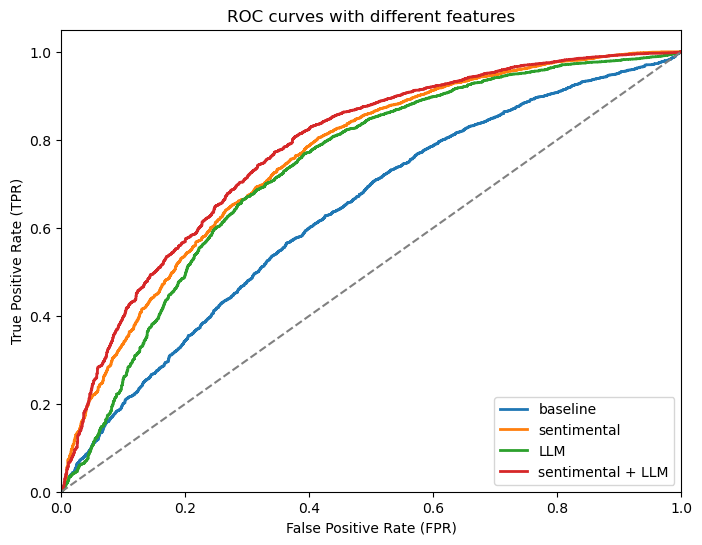

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_0, tpr_0, lw=2, label=f"baseline")
plt.plot(fpr_1, tpr_1, lw=2, label=f"sentimental")
plt.plot(fpr_2, tpr_2, lw=2, label=f"LLM")
plt.plot(fpr_3, tpr_3, lw=2, label=f"sentimental + LLM")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 随机分类器的基准线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC curves with different features")
plt.legend(loc="lower right")
#plt.show()
plt.savefig("roc.png")